In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [3]:
merged_data = pd.read_csv('C:\\Users\\USER\\Desktop\\AMDARI\\CLASS\\PERISHABLEPRODUCT\\clean\\merged_data.csv')

merged_data.head()


,Product_ID,Product_Name,Product_Category,Shelf_Life_Days,Supplier_ID,Week_Number,Store_ID,Units_Sold,Marketing_Spend,Discount_Percent,Wastage_Units,Price,Region,Store_Size,Cold_Storage_Capacity,Supplier_Name,Lead_Time_Days,Supply_Capacity,Avg_Temperature,Rainfall,Holiday_Flag
0,1000,Whole Wheat Bread 800g,Bakery,4,4,2024-W01,500,4853,670.37,0,718,2.46,London,12000,3788,PremiumGoods Wholesale,3,48776,9.9,23.0,1
1,1000,Whole Wheat Bread 800g,Bakery,4,4,2024-W01,501,1911,1280.28,0,282,3.76,Midlands,5000,1086,PremiumGoods Wholesale,3,48776,7.4,32.1,0
2,1000,Whole Wheat Bread 800g,Bakery,4,4,2024-W01,502,3080,1509.55,0,455,3.81,North East,4000,998,PremiumGoods Wholesale,3,48776,6.4,32.4,0
3,1000,Whole Wheat Bread 800g,Bakery,4,4,2024-W01,503,2856,1101.11,0,422,1.09,Midlands,5000,1243,PremiumGoods Wholesale,3,48776,7.4,32.1,0
4,1000,Whole Wheat Bread 800g,Bakery,4,4,2024-W01,504,3211,1701.66,0,475,2.72,London,10000,3330,PremiumGoods Wholesale,3,48776,9.9,23.0,1


In [146]:
# data_mutual.dtypes
merged_data.dtypes

Product_ID                 int64
Product_Name              object
Product_Category          object
Shelf_Life_Days            int64
Supplier_ID                int64
Week_Number               object
Store_ID                   int64
Units_Sold                 int64
Marketing_Spend          float64
Discount_Percent           int64
Wastage_Units              int64
Price                    float64
Month                     object
Region                    object
Store_Size                 int64
Cold_Storage_Capacity      int64
Supplier_Name             object
Lead_Time_Days             int64
Supply_Capacity            int64
Avg_Temperature          float64
Rainfall                 float64
Holiday_Flag               int64
dtype: object

Feature Leakage             		 Risk    		Explanation
                
a) Product_ID                		Safe   		    Known beforehand to identify the product.
                
b) Product_Name            		    Safe   		    A label for the product.
                
C) Product_Category           		Safe   		    Static info known before the sale.
                
d) Shelf_Life_Days          		Safe   		    Product attribute, known in advance.
                
e) Supplier_ID             		    Safe   		    Static relationship with the product.
                
f) Week_Number              		Safe   		    Time info available at prediction time.
                
g) Store_ID                		    Safe   		    Store identification before predicting its sales.
                
h) Units_Sold               		Target 		    This is the value you're trying to predict.
                
i) Marketing_Spend           		Safe  		    Planned marketing spend before sales.
                
j) Discount_Percent        		    Safe  		    Set before as a strategy
                
k) Wastage_Units             		Leaky 		     Available after sales (unsold inventory = wastage).
                
i) Price                 		    Safe  		    Set price before sales (assuming no dynamic pricing based on live sales)
                
j) Month                   		    Safe  		    Time context.
                
k) Region                 		    Safe  		    Store info known before prediction.
                
l) Store_Size               		    Safe  		    Static store attribute.
                
m) Cold_Storage_Capacity   		    Safe  	    	 Known ahead of time.
                
n) Supplier_Name             		Safe  		     A label with no impact on future info.
                
o) Lead_Time_Days              		Safe  		    If historical or average delivery time, it’s available before prediction.
                
p) Supply_Capacity             		Safe  		    If historical or static, it's safe.
                
q) Avg_Temperature 		                   Safe  	    	If it is historical avg for that time/location 
                
r) Rainfall                  		Safe    		forecasted/historical  
                
s) Holiday_Flag              		Safe  	    	Public calendar information available before prediction


In [147]:
merged_data.select_dtypes(include='number').columns.tolist()


['Product_ID',
 'Shelf_Life_Days',
 'Supplier_ID',
 'Store_ID',
 'Units_Sold',
 'Marketing_Spend',
 'Discount_Percent',
 'Wastage_Units',
 'Price',
 'Store_Size',
 'Cold_Storage_Capacity',
 'Lead_Time_Days',
 'Supply_Capacity',
 'Avg_Temperature',
 'Rainfall',
 'Holiday_Flag']

**Feature Engineering**

In [5]:
# Step 1: Storage_Suitability composite
# Multiply storage and shelf life to get composite
merged_data['Storage_Suitability'] = (
    merged_data['Cold_Storage_Capacity'] * merged_data['Shelf_Life_Days']
)
# Drop Wastage_Units if needed
merged_data.drop(columns=['Cold_Storage_Capacity', 'Shelf_Life_Days'], inplace=True)

merged_data = merged_data.reset_index(drop=True)


# Step 2: Engineering of Wastage Rolling 
# Preserve original
original_data = merged_data.copy()

# Sort, create lag & rolling, and KEEP index
sorted_data = original_data.sort_values(by=['Product_ID', 'Store_ID', 'Week_Number'])

sorted_data['Wastage_Rolling'] = (
    sorted_data.groupby(['Product_ID', 'Store_ID'])['Wastage_Units']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=[0,1], drop=True)
)

# Calculate rolling average of price (includes current week, no shift)
sorted_data['Price_Trend'] = (
    sorted_data.groupby(['Product_ID', 'Store_ID'])['Price']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=[0, 1], drop=True)
)

# Drop unwanted columns
sorted_data.drop(columns=['Wastage_Units'], inplace=True)

# Result
merged_data = sorted_data.copy()


# Step 3: Engineering of Rainfall and Temperature Deviation

# Group by Region and compute average rainfall and avg temperature
region_avg_rainfall = merged_data.groupby('Region')['Rainfall'].transform('mean')
region_avg_temp = merged_data.groupby('Region')['Avg_Temperature'].transform('mean')

# Create deviation feature
merged_data['Rainfall_Deviation'] = merged_data['Rainfall'] - region_avg_rainfall
merged_data['Temperature_Deviation'] = merged_data['Avg_Temperature'] - region_avg_temp

# Drop rainfal and avg temperature column
merged_data.drop(columns=['Rainfall', 'Avg_Temperature'], inplace=True)


# Step 4: Marketing Intensity
# Compute average marketing spend per product
product_avg_marketing = merged_data.groupby('Product_ID')['Marketing_Spend'].transform('mean')

# Reset index (optional, only needed if merged_data's index is messed up from earlier operations)
merged_data.reset_index(drop=True, inplace=True)

# Create the Marketing_Intensity feature
merged_data['Marketing_Intensity'] = merged_data['Marketing_Spend'] / (product_avg_marketing + 1)

# Drop unwanted columns
merged_data.drop(columns=['Marketing_Spend'], inplace=True)


# Step 5: Supply Incentive Ratio
merged_data['Supply_Incentive_Ratio'] = merged_data['Supply_Capacity'] / (merged_data['Discount_Percent'] + 1)

# Drop unwanted columns
merged_data.drop(columns=['Supply_Capacity', 'Discount_Percent'], inplace=True)          

# Fill NaNs with Group-Wise Constants (Safe + Interpretable)
# replace all NaNs with 0
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.fillna(0, inplace=True)

merged_data.head()

,Product_ID,Product_Name,Product_Category,Supplier_ID,Week_Number,Store_ID,Units_Sold,Price,Region,Store_Size,Supplier_Name,Lead_Time_Days,Holiday_Flag,Storage_Suitability,Wastage_Rolling,Price_Trend,Rainfall_Deviation,Temperature_Deviation,Marketing_Intensity,Supply_Incentive_Ratio
0,1000,Whole Wheat Bread 800g,Bakery,4,2024-W01,500,4853,2.46,London,12000,PremiumGoods Wholesale,3,1,15152,718.000000,2.460000,5.938462,-1.848077,1.201816,48776.000000
1,1000,Whole Wheat Bread 800g,Bakery,4,2024-W02,500,5313,3.54,London,12000,PremiumGoods Wholesale,3,0,15152,752.000000,3.000000,13.138462,-2.948077,1.413523,48776.000000
2,1000,Whole Wheat Bread 800g,Bakery,4,2024-W03,500,3620,1.41,London,12000,PremiumGoods Wholesale,3,0,15152,679.666667,2.470000,2.538462,-3.948077,0.729046,3048.500000
3,1000,Whole Wheat Bread 800g,Bakery,4,2024-W04,500,3272,1.00,London,12000,PremiumGoods Wholesale,3,0,15152,601.666667,1.983333,-0.561538,-3.348077,0.616442,8129.333333
4,1000,Whole Wheat Bread 800g,Bakery,4,2024-W05,500,3356,2.08,London,12000,PremiumGoods Wholesale,3,0,15152,505.000000,1.496667,-0.661538,-3.848077,1.375373,8129.333333


Analysis of Feature Engineering

1) Justification for Using Storage_Suitability (the composite)

a) It captures the real-world usefulness of storage. A large cold storage is only valuable if the product also lasts long. If shelf life is short, high storage capacity does not help. This feature reflects how well a product’s shelf life and storage match.

b) It combines two related ideas into one clearer metric instead of treating storage size and shelf life as separate. which helps in supply planning to avoid wastage, overstocking and understocking

c) It simplifies the model without losing insight, value and reduces complexity 

d) It helps the model learn interactions explicitly

e) It reduces redundancy and multicollinearity. Cold_Storage_Capacity influences store size while Shelf_Life_Days might influence  wastage. Both features can have direct effect on inventory and their combination avoids double-counting their impact.


2) Justification for Using Wastage_Rolling Over Wastage_Units:

a) It has a higher mutual information (MI) score, which make it informative and statistically more relevant to the target variable (Units_Sold).

b) It reduces noise from week-to-week fluctuations experienced by Wastage_Units, which can be caused by unexpected events (e.g., delivery issues, sudden demand drops). A rolling average smooths this out and captures more reliable signals.

c) The model will learn from patterns in inventory behavior (not just isolated spikes), which better reflect ongoing overstocking or underutilization issues.

d) Rolling features are less sensitive to outliers, reduces the risk of overfitting to random noise in the data and improve model stability and generalization

e) It aligns with project goal of improving supply efficiency and reducing wastage over time.

f) It uses only past data, which make it avoid data leakage and safe forecasting.


3) Justification for Engineering Rainfall & Temperature Deviation Features:

a) Deviation features center the data around the region’s baseline (local climate differences), which allows the model to learn from relative weather anomalies.

b) Deviation features help capture weather-driven demand spikes or drops (e.g. unusually hot weeks driving cold product sales)

c) It improves interpretability as a deviation value of +5°C or -20mm is easier to interpret than raw values. It directly shows whether it was hotter, colder, wetter, or drier than usual.

d) It aligns with operational decision-making as businesses respond to weather anomalies and not just the raw numbers

e) It is statistically more meaningful for machine learning as it has higher MI score


4) Justification for Engineering Marketing Intensity

a) Marketing Intensity shows how aggressively a product is marketed relative to its usual average and this help compare across products with high or low marketing budgets. This help concentrate marketing budget on products that show measurable lift

b) It controls product level bias and levels the playing field without favoring high-budget items.

c) It prevents the model from being biased just because one product always gets more budget and helps the model generalizes better on future data

d) Raw Marketing_Spend could be heavily skewed or have outliers but Marketing_Intensity reduces variability and brings values closer to a standard range that improves interpretability


4) Justification for Engineering Supply Incentive Ratio

a) It captures the true supply motivation of better margins by delivering more stock when supply is high and discounts are low. This balances how much can be supplied versus how much is being given away as a discount.

b) It makes incentives comparable across products. Products with different discount and supply dynamics become easier to compare. The ratio also shows who is getting more favorable terms and not just who gets more supply.

c) It helps the model understand trade-offs automatically by directly encodes that logic instead of expecting the model to figure out that a high supply with low discount is better. 

d) It reduces dimensionality and collinearity as they may be related. The combination also reduces redundancy and overfitting.

In [157]:
print(f"Original shape: {original_data.shape}")
print(f"After dropna: {sorted_data.shape}")
print(f"merged_data: {merged_data.shape}")

Original shape: (37440, 21)
After dropna: (37440, 22)
merged_data: (37440, 21)


In [158]:
merged_data.isna().sum()

Product_ID                0
Product_Name              0
Product_Category          0
Supplier_ID               0
Week_Number               0
Store_ID                  0
Units_Sold                0
Price                     0
Month                     0
Region                    0
Store_Size                0
Supplier_Name             0
Lead_Time_Days            0
Holiday_Flag              0
Storage_Suitability       0
Wastage_Rolling           0
Price_Trend               0
Rainfall_Deviation        0
Temperature_Deviation     0
Marketing_Intensity       0
Supply_Incentive_Ratio    0
dtype: int64

** Correlation Matrix and VIF**

A correlation matrix is a quick diagnostic tool to ensure clean, non-redundant features in the dataset.

The Variance Inflation Factor (VIF)  tells how much each feature is linearly predictable from the others


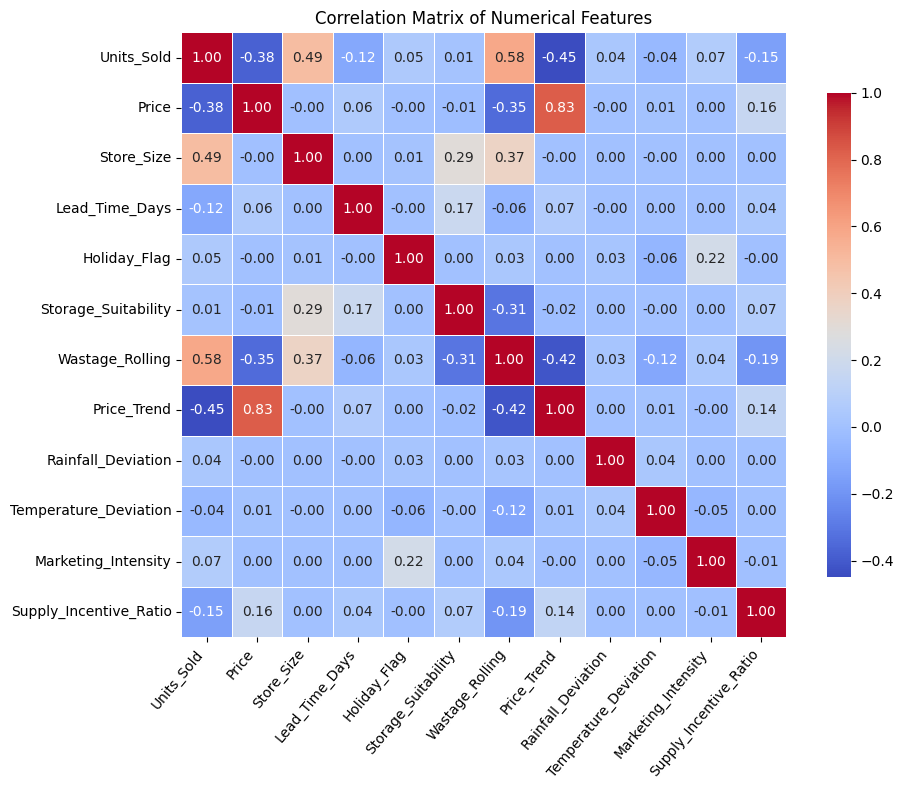

                   Feature       VIF
0               Units_Sold  2.104131
1                    Price  3.231287
2               Store_Size  1.965790
3           Lead_Time_Days  1.060326
4             Holiday_Flag  1.055244
5      Storage_Suitability  1.617691
6          Wastage_Rolling  2.345941
7              Price_Trend  3.788334
8       Rainfall_Deviation  1.005719
9    Temperature_Deviation  1.036092
10     Marketing_Intensity  1.058651
11  Supply_Incentive_Ratio  1.063806


In [159]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Make copy and delete identifiers
corr_data = merged_data.copy()
corr_data.drop(columns=['Product_ID', 'Supplier_ID', 'Store_ID'], inplace=True)

# Select only numerical columns
numerical_df = corr_data.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=50,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Compute VIF
# Assuming numerical_df is already defined and cleaned
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_data, i) for i in range(scaled_data.shape[1])]

print(vif_data)


**Correlation Matrix Insights**:

Key Variable: Units_Sold (Target)

a) Strongest Positive Correlation: Wastage_Rolling (0.58) indicates higher wastage is associated with more units sold which could suggest overstocking in high-demand areas. Store_Size (0.49) shows larger stores tend to sell more units (as expected).

b) Strongest Negative Correlation: Price_Trend (-0.45) and Price (-0.38) indicate if the price trends upward, unit sold tend to drop. This is a typical demand response in line with standard economic behaviour.

c) Feature Interrelationships: Price and Price_Trend have very Strong Positive Correlation (0.83) and this may lead to redundancy due to their multicolinearity. Store_Size and Wastage_Rolling have moderate correlation (0.37) wich indicate larger stores may naturally generate more waste. This is expected, but worth monitoring.

d) Low or No Correlation (with Units_Sold): Holiday_Flag, Storage_Suitability, Rainfall_Deviation, Temperature_Deviation, Marketing_Intensity, Supply_Incentive_Ratio have correlations all near zero (0). These features may have limited predictive power in a linear sense but could still be useful, have high impact in non-linear models (e.g. tree-based).


**VIF Analysis**:

The general interpretation rules: 

VIF < 5 (Low multicollinearity) is good and  acceptable.

VIF ≥ 5 (Moderate multicollinearity) needs attention

VIF ≥ 10 (Severe multicollinearity) is problematic.

Feature-Level Insights

a) Low VIF: Wastage_Rolling (2.35) have low VIF which is acceptable but may correlate with other feature. Price_Trend (3.79) and Price (3.23) also have low VIF but moderate collinearity. This is due to overlapping information with each other and may lead to redundancy

b) Very Low VIF: Rainfall_Deviation (1.01), Temperature_Deviation (1.04), Holiday_Flag (1.05), Lead_Time_Days (1.06), Storage_Suitability (1.62), Marketing_Intensity (1.06), Supply_Incentive_Ratio (1.06) and Store_Size (1.97) have no collinearity and are acceptable.

c) All the features have no severe multicollinearity (all VIF < 5 → good) and are statistically safe with minimal risk of inflating variances. This matches the correlation matrix explained above.


**RECOMMENDATION**

a) Consider dropping one of Price or Price_Trend as they are moderately correlated (0.83) and both have VIF > 3. Keeping both inflates multicollinearity.  

b) Choose based on domain knowledge and non-linear impact on the target (unit_sold). If price_trend constraints are more relevant, keep Price_Trend and if price is key, keep price

c) Keep other features since they have low to moderate correlation and until further assessment with mutual information regression 


**Feature Encoding**

In [6]:
# List out objects in the merged dataset
merged_data.select_dtypes(include='O').columns.tolist()

['Product_Name',
 'Product_Category',
 'Week_Number',
 'Month',
 'Region',
 'Supplier_Name']

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Copy original data
encode_data = merged_data.copy()

nominal_columns = ['Product_Category', 'Region']  # one hot
high_cardinal = ['Product_Name']  # mean encoding

# OneHot Encoding for nominal columns

ohe = OneHotEncoder(sparse_output=False)

encoded_columns = []

# OneHot Encoding
for col in nominal_columns:
    transformed_col = ohe.fit_transform(encode_data[[col]])
    transformed_df = pd.DataFrame(transformed_col, columns = [f"{col}_{cat}" for cat in ohe.categories_[0]])

    encoded_columns.append(transformed_df)

# Combine
encode_data = pd.concat([encode_data] + encoded_columns, axis = 1)
encode_data.drop(columns = nominal_columns, inplace = True)

# Mean Encoding for high-cardinality columns using 'Price' as mean
mean_encoders = {}

for col in high_cardinal:
    mean_encode = encode_data.groupby(col)['Price'].mean()
    encode_data[col] = encode_data[col].map(mean_encode)

    mean_encoders[col] = mean_encode

encode_data.to_csv('encode_data.csv', index=False)
encode_data.head()


,Product_ID,Product_Name,Supplier_ID,Week_Number,Store_ID,Units_Sold,Price,Month,Store_Size,Supplier_Name,Lead_Time_Days,Holiday_Flag,Storage_Suitability,Wastage_Rolling,Price_Trend,Rainfall_Deviation,Temperature_Deviation,Marketing_Intensity,Supply_Incentive_Ratio,Product_Category_Bakery,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Region_London,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West
0,1000,2.439103,4,2024-W01,500,4853,2.46,2024-01,12000,PremiumGoods Wholesale,3,1,15152,718.000000,2.460000,5.938462,-1.848077,1.201816,48776.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1000,2.439103,4,2024-W02,500,5313,3.54,2024-01,12000,PremiumGoods Wholesale,3,0,15152,752.000000,3.000000,13.138462,-2.948077,1.413523,48776.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1000,2.439103,4,2024-W03,500,3620,1.41,2024-01,12000,PremiumGoods Wholesale,3,0,15152,679.666667,2.470000,2.538462,-3.948077,0.729046,3048.500000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1000,2.439103,4,2024-W04,500,3272,1.00,2024-01,12000,PremiumGoods Wholesale,3,0,15152,601.666667,1.983333,-0.561538,-3.348077,0.616442,8129.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1000,2.439103,4,2024-W05,500,3356,2.08,2024-01,12000,PremiumGoods Wholesale,3,0,15152,505.000000,1.496667,-0.661538,-3.848077,1.375373,8129.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Convert to datetime columns

merged_data['Week_Number'] = pd.to_datetime(merged_data['Week_Number'] + '-1', format='%G-W%V-%u')

merged_data['Week_Number']


0       2024-01-01
1       2024-01-08
2       2024-01-15
3       2024-01-22
4       2024-01-29
           ...    
37435   2024-11-25
37436   2024-12-02
37437   2024-12-09
37438   2024-12-16
37439   2024-12-23
Name: Week_Number, Length: 37440, dtype: datetime64[ns]

In [10]:
# If Month is already PeriodDtype, convert it to datetime

merged_data['Month'] = (merged_data['Month'].astype(str).str.strip().pipe(pd.to_datetime, format="%Y-%m", errors="coerce"))

merged_data['Month']

0       2024-01-01
1       2024-01-01
2       2024-01-01
3       2024-01-01
4       2024-01-01
           ...    
37435   2024-11-01
37436   2024-12-01
37437   2024-12-01
37438   2024-12-01
37439   2024-12-01
Name: Month, Length: 37440, dtype: datetime64[ns]

In [11]:
date_col_to_engineer = merged_data.select_dtypes(include='datetime64').columns.tolist()

for col in date_col_to_engineer:
    encode_data[col + '_Year'] = merged_data[col].dt.year
    encode_data[col + '_Month'] = merged_data[col].dt.month
    encode_data[col + '_Day'] = merged_data[col].dt.day

    encode_data.drop(columns=[col], inplace=True)

In [12]:
encode_data.to_csv('encode.csv', index=False)
encode_data.head()

,Product_ID,Product_Name,Supplier_ID,Store_ID,Units_Sold,Price,Store_Size,Supplier_Name,Lead_Time_Days,Holiday_Flag,Storage_Suitability,Wastage_Rolling,Price_Trend,Rainfall_Deviation,Temperature_Deviation,Marketing_Intensity,Supply_Incentive_Ratio,Product_Category_Bakery,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Region_London,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Week_Number_Year,Week_Number_Month,Week_Number_Day,Month_Year,Month_Month,Month_Day
0,1000,2.439103,4,500,4853,2.46,12000,PremiumGoods Wholesale,3,1,15152,718.000000,2.460000,5.938462,-1.848077,1.201816,48776.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,1,2024,1,1
1,1000,2.439103,4,500,5313,3.54,12000,PremiumGoods Wholesale,3,0,15152,752.000000,3.000000,13.138462,-2.948077,1.413523,48776.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,8,2024,1,1
2,1000,2.439103,4,500,3620,1.41,12000,PremiumGoods Wholesale,3,0,15152,679.666667,2.470000,2.538462,-3.948077,0.729046,3048.500000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,15,2024,1,1
3,1000,2.439103,4,500,3272,1.00,12000,PremiumGoods Wholesale,3,0,15152,601.666667,1.983333,-0.561538,-3.348077,0.616442,8129.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,22,2024,1,1
4,1000,2.439103,4,500,3356,2.08,12000,PremiumGoods Wholesale,3,0,15152,505.000000,1.496667,-0.661538,-3.848077,1.375373,8129.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,29,2024,1,1


**Feature Selection**

Mutual_info_regression was used for final feature selection as it measures how much information each feature gives about the target variable (unit sold) in this regression task. astype('category') was also used to converts all object (string) columns in X below to categorical type using pandas.

In [175]:
# Drop Identifiers 
identifiers = ['Product_ID', 'Supplier_ID', 'Store_ID']
merged_data.drop(columns=['Product_ID', 'Supplier_ID', 'Store_ID', ], inplace=True)

# Drop Price (it has been re-engineered) 
merged_data.drop(columns=['Price'], inplace=True)


In [176]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Copy original data
mi_data = merged_data.copy()

# Define the feature and target matrix
X = mi_data.drop(columns=['Units_Sold'])
target = mi_data['Units_Sold']

# Convert string/object columns to category type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Compute mutual information scores
mi_scores = mutual_info_regression(X, target, discrete_features=True, random_state=42)

# Create DataFrame of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display the result
print(feature_importance)


                   Feature  MI_Score
9      Storage_Suitability  0.485788
14     Marketing_Intensity  0.437358
10         Wastage_Rolling  0.434249
1         Product_Category  0.335047
0             Product_Name  0.329353
11             Price_Trend  0.225382
12      Rainfall_Deviation  0.179366
13   Temperature_Deviation  0.179016
4                   Region  0.142177
5               Store_Size  0.134966
15  Supply_Incentive_Ratio  0.087613
6            Supplier_Name  0.073028
2              Week_Number  0.028475
3                    Month  0.019327
7           Lead_Time_Days  0.008996
8             Holiday_Flag  0.002175


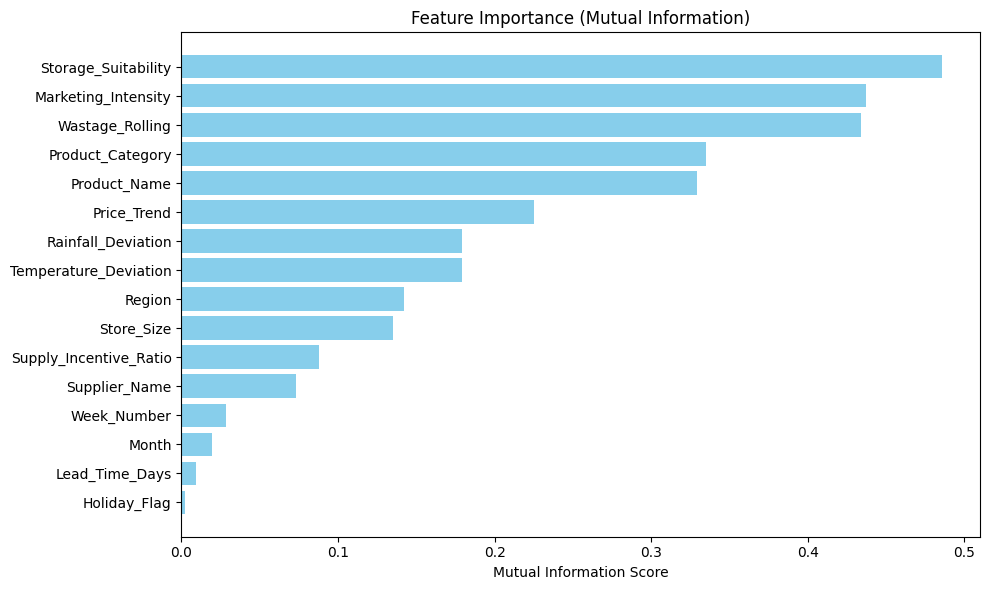

In [177]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


Analyses of features importance from Mutual Information: 

Mutual Information shows how much each feature contributes to predicting the target variable, based on any kind of dependency (not just linear). High MI score shows strong relationship with the target while low MI score indicates weak or no relationship.

a) Top Predictors: Storage suitability (0.485788) is the most informative feature for predicting Units_Sold and it suggests that products with better shelf life & cold storage capacity significantly affect the target (demand and wastage). This aligns  well with the goal of optimizing seasonal and perishable inventory. Marketing_Intensity (0.437358) strong contributors that reflects how aggressive or high marketing efforts influence supply or demand outcomes. Wastage_Rolling (0.434249) also is a strong temporal feature engineering that suggests past wastage trends can significantly contribute to model understanding of overstocking and understocking.

b) Moderate Features: Product_Category (0.335047) and  Product_Name (0.329353) show product identity and type are relevant to sales performance. Price_Trend (0.225382) indicates pricing behavior over time affects unit_sold but less predictive than wastage trend.
Rainfall_Deviation & Temperature_Deviation (approx. 0.18) indicate that weather anomalies have a moderate impact on sales. This effect is likely driven by shifts in consumer behavior or the sensitivity of perishable products to weather conditions. Region (0.142177) and Store_Size (0.134966) also add some marginal value to the target and this may be due to consumer demographics, cultural tastes and dietary habit and supply chain accessibility. 

c) Low-to-Negligible Importance Features: Despite Supply_Incentive_Ratio (0.087613) been engineered,its predictive power is limited alongside with  Supplier_Name (0.073028). However, they are useful for segmenting and interactions. The time-based variables i.e. Week_Number (0.028475), Month (0.019327), Lead_Time_Days (0.008996) and  Holiday_Flag (0.002175) have low MI scores and this is due to weak direct impact on the target (Units_Sold). However, Week_Number was used for sorting while others do not have enough interaction with other features (e.g., no holiday-product link)

Conclusion: The feature engineering is strong and meaningful, with top features clearly aligned with business logic (shelf life, marketing, historical wastage).

Recommendations:

a. Focus on the first ten top predictors for training the model.

b. Drop very low score features that may add noise

In [178]:
# Save top 10 features from MI
selected_features = feature_importance['Feature'].head(10).tolist()
selected_features

['Storage_Suitability',
 'Marketing_Intensity',
 'Wastage_Rolling',
 'Product_Category',
 'Product_Name',
 'Price_Trend',
 'Rainfall_Deviation',
 'Temperature_Deviation',
 'Region',
 'Store_Size']

**Model Data**

In [179]:
# Target variable
target = merged_data['Units_Sold']

# Training features selected from MI top ten
training_features_list = ['Storage_Suitability', 'Marketing_Intensity', 'Wastage_Rolling', 'Product_Category', 'Product_Name',  
                          'Price_Trend', 'Rainfall_Deviation', 'Temperature_Deviation', 'Region', 'Store_Size'] # Mix of categoricals and Numericals

# Training_features = base_features + encoded_features
base_features_df = merged_data[['Storage_Suitability', 'Marketing_Intensity', 'Wastage_Rolling', 'Price_Trend', 'Rainfall_Deviation', 
                                'Temperature_Deviation', 'Store_Size']] # Numericals columns


encoded_features_df = encode_data[['Product_Category_Beverages', 'Product_Category_Dairy', 'Product_Category_Meat', 'Product_Name',
                                   'Region_Midlands', 'Region_North East', 'Region_North West','Region_South East', 'Region_South West']] # Encoded columns

# Combine original and encoded features side by side
model_data = pd.concat([base_features_df, encoded_features_df, target], axis=1)


# Check result
print(model_data.shape)
model_data.head()



(37440, 17)


,Storage_Suitability,Marketing_Intensity,Wastage_Rolling,Price_Trend,Rainfall_Deviation,Temperature_Deviation,Store_Size,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Product_Name,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Units_Sold
0,15152,1.201816,718.000000,2.460000,5.938462,-1.848077,12000,0.0,0.0,0.0,2.439103,0.0,0.0,0.0,0.0,0.0,4853
1,15152,1.413523,752.000000,3.000000,13.138462,-2.948077,12000,0.0,0.0,0.0,2.439103,0.0,0.0,0.0,0.0,0.0,5313
2,15152,0.729046,679.666667,2.470000,2.538462,-3.948077,12000,0.0,0.0,0.0,2.439103,0.0,0.0,0.0,0.0,0.0,3620
3,15152,0.616442,601.666667,1.983333,-0.561538,-3.348077,12000,0.0,0.0,0.0,2.439103,0.0,0.0,0.0,0.0,0.0,3272
4,15152,1.375373,505.000000,1.496667,-0.661538,-3.848077,12000,0.0,0.0,0.0,2.439103,0.0,0.0,0.0,0.0,0.0,3356


In [180]:
# Desired order of impact to target: 
desired_order = ['Storage_Suitability', 
                 'Marketing_Intensity', 
                 'Wastage_Rolling',     
                 'Product_Category_Beverages',
                 'Product_Category_Dairy',
                 'Product_Category_Meat',
                 'Product_Name',
                 'Price_Trend',
                 'Rainfall_Deviation',
                 'Temperature_Deviation',
                 'Region_Midlands',
                 'Region_North East',
                 'Region_North West',
                 'Region_South East',
                 'Region_South West',
                 'Store_Size',
                 'Units_Sold'] 
  

# Reorder the DataFrame using your predefined list
model_data = model_data[desired_order]

# Preview the result
model_data.head()


,Storage_Suitability,Marketing_Intensity,Wastage_Rolling,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Product_Name,Price_Trend,Rainfall_Deviation,Temperature_Deviation,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Store_Size,Units_Sold
0,15152,1.201816,718.000000,0.0,0.0,0.0,2.439103,2.460000,5.938462,-1.848077,0.0,0.0,0.0,0.0,0.0,12000,4853
1,15152,1.413523,752.000000,0.0,0.0,0.0,2.439103,3.000000,13.138462,-2.948077,0.0,0.0,0.0,0.0,0.0,12000,5313
2,15152,0.729046,679.666667,0.0,0.0,0.0,2.439103,2.470000,2.538462,-3.948077,0.0,0.0,0.0,0.0,0.0,12000,3620
3,15152,0.616442,601.666667,0.0,0.0,0.0,2.439103,1.983333,-0.561538,-3.348077,0.0,0.0,0.0,0.0,0.0,12000,3272
4,15152,1.375373,505.000000,0.0,0.0,0.0,2.439103,1.496667,-0.661538,-3.848077,0.0,0.0,0.0,0.0,0.0,12000,3356


Model Training

Scaling: StandardScaler was applied to ensure that all features contribute equally to the model, preventing those with larger numerical ranges from dominating. It also helps optimization algorithms work more efficiently by improving the convergence of gradient-based models like Linear Regression.

In [181]:
# Training a Base Model

def train_linear_regression_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import (
        mean_squared_error,
        r2_score,
        mean_absolute_error,
        mean_absolute_percentage_error
    )
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)

    # Step 5: Save the model
    import pickle 
    with open('lr_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 6: Predict on scaled test set
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 7: Inverse transform predictions and actual values
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 8: Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 9: Print evaluation metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [182]:

model_data = model_data = model_data[desired_order]
model = train_linear_regression_model(model_data)

MSE: 382101.7838
RMSE: 618.1438
R² Score: 0.7336
MAE: 422.1364
MAPE: 0.2884


In [183]:
def train_rf_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.preprocessing import OneHotEncoder
    import joblib
    import json
    import os
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame/Series
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train Random Forest Regressor
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_scaled, y_train_scaled)
    
    # Step 5: Save the model
    import pickle 
    with open('rf_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 6: Predict (still in scaled units)
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 7: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 8: Evaluate using real-world values
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 9: Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [184]:
model_data = model_data = model_data[desired_order]
model = train_rf_model(model_data)

MSE: 271585.7552
RMSE: 521.1389
R² Score: 0.8107
MAE: 350.2450
MAPE: 0.2320


In [185]:
def train_svr_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVR
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train SVR
    model = SVR()
    model.fit(X_train_scaled, y_train_scaled.ravel())  # SVR expects 1D target

    # Step 5: Save the model
    import pickle 
    with open('svr_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 6: Predict (still in scaled units)
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 7: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Step 8: Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 9: Print results
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [186]:
model_data = model_data = model_data[desired_order]
model = train_svr_model(model_data)

MSE: 281590.3769
RMSE: 530.6509
R² Score: 0.8037
MAE: 356.0343
MAPE: 0.2326


In [187]:
def train_xgboost_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train XGBoost Regressor
    model = XGBRegressor(random_state=42)
    model.fit(X_train_scaled, y_train_scaled.ravel())

    # Step 6: Save the model
    import pickle 
    with open('xgboost_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 6: Predict
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 7: Inverse transform
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Step 8: Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 9: Print results
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [188]:
model_data = model_data = model_data[desired_order]
model = train_xgboost_model(model_data)

MSE: 272153.7645
RMSE: 521.6836
R² Score: 0.8103
MAE: 345.9111
MAPE: 0.2276


Hyperparameter Tuning

In [189]:
def train_rf_randomsearchcv_model(data, target_column='Units_Sold'): 
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    from scipy.stats import randint
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame/Series
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Define parameter grid for tuning
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(5, 30),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'max_features': [None, 'sqrt', 'log2']
    }

    # Step 5: Randomized Search CV
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

    random_search = RandomizedSearchCV(
        rf_model,
        param_distributions=param_dist,
        n_iter=30,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Step 6: Fit the model
    random_search.fit(X_train_scaled, y_train_scaled)

    # Step 7: Save the model
    import pickle 
    best_model = random_search.best_estimator_
    
    rf_randomsearchcv_model = {
    'model': best_model,
    'feature_scaler': feature_scaler,
    'target_scaler': target_scaler,
    'best_params': random_search.best_params_
    }

    with open('rf_randomsearchcv_model.pkl', 'wb') as file:
        pickle.dump(rf_randomsearchcv_model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)
    

    # Step 8: Evaluate
    best_model = random_search.best_estimator_
    y_pred_scaled = best_model.predict(X_test_scaled)

    # Step 9: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 10: Evaluate using real-world values
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 11: Print metrics
    print("\n Best Hyperparameters:", random_search.best_params_)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return best_model, random_search.best_params_, feature_scaler, target_scaler



In [191]:
model_data = model_data[desired_order]
model = train_rf_randomsearchcv_model(model_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

 Best Hyperparameters: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 364}
MSE: 257954.6285
RMSE: 507.8923
R² Score: 0.8202
MAE: 340.1081
MAPE: 0.2254


In [192]:
def train_rf_optuna_model(data, target_column='Units_Sold', n_trials=30, test_size=0.3, random_state=42):
    import optuna
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd


    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame/Series
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=test_size, random_state=random_state
    )

    # Step 4: Define Optuna objective function
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': random_state,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params)
        scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=3, scoring='neg_root_mean_squared_error')
        return -scores.mean()  # Optuna minimizes, so we return negative RMSE

    # Step 5: Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, timeout=600)

    # Step 6: Train best model on full training data
    best_params = study.best_params
    best_model = RandomForestRegressor(**best_params)
    best_model.fit(X_train_scaled, y_train_scaled)

    # Step 7: Save the model
    import pickle 
    with open('rf_optuna_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 8: Predict and inverse transform
    y_pred_scaled = best_model.predict(X_test_scaled)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 9: Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 9: Output
    print("\n Best Hyperparameters from Optuna:", best_params)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    return best_model, best_params, feature_scaler, target_scaler


In [193]:
model_data = model_data = model_data[desired_order]
model = train_rf_optuna_model(model_data)

[I 2025-10-28 23:54:21,209] A new study created in memory with name: no-name-744d25fc-f12a-4e3c-918f-20aabc4aaa41
[I 2025-10-28 23:54:26,610] Trial 0 finished with value: 0.43498274643888796 and parameters: {'n_estimators': 140, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.43498274643888796.
[I 2025-10-28 23:54:44,027] Trial 1 finished with value: 0.43330342828074 and parameters: {'n_estimators': 458, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.43330342828074.
[I 2025-10-28 23:54:57,015] Trial 2 finished with value: 0.4346410202101581 and parameters: {'n_estimators': 280, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.43330342828074.
[I 2025-10-28 23:55:01,377] Trial 3 finished with value: 0.4345534339679938 and parameters: {'n_estimators': 103, 'max_depth': 26, 'min_s


 Best Hyperparameters from Optuna: {'n_estimators': 352, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None}
MSE: 259476.7792
RMSE: 509.3886
R² Score: 0.8191
MAE: 340.6769
MAPE: 0.2258


In [194]:
def train_rf_gridsearchcv_model(data, target_column='Units_Sold'): 
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    from scipy.stats import randint
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame/Series
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Define parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 4],
        'max_features': ['sqrt', 'log2'] # 'auto' not supported in recent versions
    }

     # Step 5: Randomized Search CV
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

    random_search = GridSearchCV(
        estimator=rf_model,
        param_grid= param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    # Step 6: Fit the model
    random_search.fit(X_train_scaled, y_train_scaled)

    # Step 7: Save the model
    import pickle 
    with open('rf_gridsearchcv.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 7: Evaluate
    best_model = random_search.best_estimator_
    y_pred_scaled = best_model.predict(X_test_scaled)

    # Step 8: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 9: Evaluate using real-world values
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 10: Print metrics
    print("\n Best Hyperparameters:", random_search.best_params_)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return best_model, random_search.best_params_, feature_scaler, target_scaler



In [195]:
model_data = model_data = model_data[desired_order]
model = train_rf_gridsearchcv_model(model_data)


Fitting 3 folds for each of 72 candidates, totalling 216 fits

 Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
MSE: 271611.0228
RMSE: 521.1631
R² Score: 0.8106
MAE: 349.4214
MAPE: 0.2322


Metric Analyses:

a) Optimized Random Forest (Random Forest with hyperparameter tuning using RandomizedSearchCV): It is the best performing model overall. It has the lowest average squared error (MSE: 257,955), lowest predictions closest to actual values (RMSE: 507.89), highest significant better fit of explaining approximate 82% of target variance (R²: Score 0.8202), smallest average absolute error (MAE: 340.11), lowest error rate of 22.5% (MAPE: 0.2254)

b) Random Forest with hyperparameter tuning using Optuna: The model metrics are very close to RandomizedSearchCV model but slightly have higher errors across the board. Although, it still strong in real-world MAE and MAPE.

c)Logistic Regression and XGBoost: Both models are also strong performers, but slightly behind Random Forest with Optuna model

d) Random Forest with hyperparameter tuning using GridsearchCV and SVR: Both model performance are close buy have slightly higher errors than the earlier mentioned models

e) Linear Regression: It is the weakest model that captures least variance (lowest R²: 0.7336), highest errors in all metrics: MSE, RMSE, MAE, MAPE. 

Result Interpretation:

Random Forest with hyperparameter tuning using RandomizedSearchCV outperforms all the other models across all metrics. It delivers higher accuracy, lowest prediction error, captures non-linear patterns, and generalizes on unseen data better, making it the superior choice for production deployment in this case. Besides, all models perform reasonably well (R² > 0.73), but there's a clear progression in performance.

Recommendations:

i) Use Random Forest with hyperparameter tuning using RandomizedSearchCV for inference and deployment.

ii) Linear regression may need re-tuning or feature reconsideration.

iii) Random Forest with hyperparameter tuning using Optuna could serve as a fallback to Random Forest with hyperparameter tuning using RandomizedSearchCV 




